# LV-Network Design Example 2

In [1]:
from python_electric import (
    Q_,
    NetworkTopology,
    LoadInput,
    TransformerInput,
    CableInput,
    ConductorMaterial,
    InsulationMaterial,
    InstallMethod,
    CableMounting,
    CableArrangement,
    EarthingSystem,
    VoltReference,
    CircuitBreaker
)

## Step 1: Create Loads and Network Topology

In [2]:
network = NetworkTopology(
    name="network",
    U_lv=Q_(400, 'V'),
    earthing_system=EarthingSystem.IT,
    neutral_distributed=False
)

# SOURCE CONNECTION
network.add_source_grid_connection(
    conn_id="C0",
    end_id="MV_BUS",
    U_l=Q_(11, 'kV'),
    S_sc=Q_(500, 'MVA')
)

network.add_connection(
    conn_id="C1",
    start_id="MV_BUS",
    end_id="B2_BUS",
    load_data=LoadInput(
        U_l=Q_(420, 'V'),
        cos_phi=1.0,
        P_e=Q_(1000, 'kVA')
    )
)

network.add_connection(
    conn_id="C6",
    start_id="B2_BUS",
    end_id="T6_BUS",
    load_data=LoadInput(
        U_l=Q_(400, 'V'),
        cos_phi=1.0,
        P_e=Q_(400, 'kVA')
    )
)

## Step 2: Add Components to Network Connections

### Transformer T1 (C1)

In [3]:
T1_dat = TransformerInput(
    name="T1",
    S_n=Q_(1000, 'kVA'),
    U_lp=Q_(11, 'kV'),
    U_ls=network.U_lv,
    u_cc=Q_(6, 'pct'),
    P_Cu=Q_(12.7, 'kW'),
    pri_conn=TransformerInput.WindingConn.D,
    sec_conn=TransformerInput.WindingConn.Y
)
network.add_component("C1", T1_dat)

### Cable C1 (C1)

In [4]:
cable_C1_dat = CableInput(
    name="cable_C1",
    L=Q_(5, 'm'),
    conductor_material=ConductorMaterial.COPPER,
    insulation_material=InsulationMaterial.PVC,
    T_amb=Q_(30, 'degC'),
    install_method=InstallMethod.F,
    cable_mounting=CableMounting.PERFORATED_TRAY,
    cable_arrangement=CableArrangement.SINGLE_CORE_TOUCHING,
    earthing_system=EarthingSystem.IT,
    num_other_circuits=0,
    n_phase=6,
    sizing_based_on_I_nom=True
)
network.add_component("C1", cable_C1_dat)

**Conductor Cross-Sectional Area**

In [5]:
from python_electric import Cable

cable_C1: Cable = network.get_component("cable_C1")

print(
    f"load current per phase: {cable_C1.I_b_tot.to('A'):~P.0f}",
    f"single-core cables per phase: {cable_C1.n_phase}",
    f"load current per single-core cable: {cable_C1.I_b.to('A'):~P.0f}",
    f"required min. CSA: {cable_C1.S.to('mm**2'):~P.0f}",
    sep="\n"
)

load current per phase: 1375 A
single-core cables per phase: 6
load current per single-core cable: 229 A
required min. CSA: 150 mm²


### Cable C6 (C6)

In [6]:
cable_C6_dat = CableInput(
    name="cable_C6",
    L=Q_(15, 'm'),
    conductor_material=ConductorMaterial.COPPER,
    insulation_material=InsulationMaterial.PVC,
    T_amb=Q_(30, 'degC'),
    install_method=InstallMethod.F,
    cable_mounting=CableMounting.PERFORATED_TRAY,
    cable_arrangement=CableArrangement.SINGLE_CORE_TOUCHING,
    earthing_system=EarthingSystem.IT,
    num_other_circuits=0,
    n_phase=1
)
network.add_component("C6", cable_C6_dat)

**Conductor Cross-Sectional Area**

In [7]:
cable_C6: Cable = network.get_component("cable_C6")

print(
    f"load current per phase: {cable_C6.I_b_tot.to('A'):~P.0f}",
    f"single-core cables per phase: {cable_C6.n_phase}",
    f"load current per single-core cable: {cable_C6.I_b.to('A'):~P.0f}",
    f"required min. CSA: {cable_C6.S.to('mm**2'):~P.0f}",
    sep="\n"
)

load current per phase: 577 A
single-core cables per phase: 2
load current per single-core cable: 289 A
required min. CSA: 150 mm²


## Step 3: Calculate Voltage Drop

### Steady-State Line-to-Ground Voltage Drop at Bus T6

The voltage drop is calculated with reference to ground, i.e. the drop of ground-to-line voltage between source bus 'MV_BUS' and bus 'T6_BUS'.

In [8]:
dU_T6, dU_rel_T6 = network.get_voltage_drop_at_bus("T6_BUS")

print(
    f"Absolute voltage drop: {dU_T6.to('V'):~P.2f}",
    f"Relative voltage drop: {dU_rel_T6.to('pct'):~P.2f}",
    sep="\n"
)

Absolute voltage drop: 3.15 V
Relative voltage drop: 1.37 %


### Steady-State Line-to-Ground Voltage Drop across Connection C1

The voltage drop across a connection is calculated with reference to ground.

In [9]:
dU_C1, dU_rel_C1 = network.get_voltage_drop_of_conn("C1")

print(
    f"Absolute voltage drop: {dU_C1.to('V'):~P.2f}",
    f"Relative voltage drop: {dU_rel_C1.to('pct'):~P.2f}",
    sep="\n"
)

Absolute voltage drop: 2.85 V
Relative voltage drop: 1.23 %


### Steady-State Line-to-Ground Voltage Drop across Connection C6

In [10]:
dU_C6, dU_rel_C6 = network.get_voltage_drop_of_conn("C6")

print(
    f"Absolute voltage drop: {dU_C6.to('V'):~P.2f}",
    f"Relative voltage drop: {dU_rel_C6.to('pct'):~P.2f}",
    sep="\n"
)

Absolute voltage drop: 0.31 V
Relative voltage drop: 0.13 %


### Steady-State Voltage Drop across Transformer T1

At instantiation of the `Transformer`-object, the voltage drop across the transformer is calculated based on the load of the connection to which the transformer belongs. This voltage drop is referenced to ground.

In [11]:
from python_electric import Transformer

T1: Transformer = network.get_component("T1")

print(
    f"Absolute voltage drop: {T1.dU.to('V'):~P.2f}",
    f"Relative voltage drop: {T1.dU_rel.to('pct'):~P.2f}",
    sep="\n"
)

Absolute voltage drop: 2.82 V
Relative voltage drop: 1.22 %


All voltage drops in the network are calculated with reference to ground by default. However, the voltage drop across the transformer can also be calculated more generally by calling the `get_voltage_drop(...)` method of the `Transformer` object. With this method, the three-phase voltage drop can be referenced either to ground (drop of line-to-ground voltage) or between any two lines (drop of line-to-line voltage). By setting parameter `volt_ref` to `VoltReference.PH3_LINE_TO_LINE`, the line-to-line voltage drop can be retrieved. 

In [12]:
dU_T1, dU_rel_T1 = T1.get_voltage_drop(
    U_l=T1.U_ls,
    I_b=T1.I_b,
    cos_phi=T1.cos_phi,
    volt_ref=VoltReference.PH3_LINE_TO_LINE
)

print(
    f"Absolute voltage drop: {dU_T1.to('V'):~P.2f}",
    f"Relative voltage drop: {dU_rel_T1.to('pct'):~P.2f}",
    sep="\n"
)

Absolute voltage drop: 4.88 V
Relative voltage drop: 1.22 %


### Steady-State Voltage Drop across Cable C1

At instantiation of the `Cable`-object, the voltage drop across the cable is calculated based on the load of the connection to which the cable belongs. This voltage drop is referenced to ground.

In [13]:
print(
    f"Absolute voltage drop: {cable_C1.dU.to('V'):~P.2f}",
    f"Relative voltage drop: {cable_C1.dU_rel.to('pct'):~P.2f}",
    sep="\n"
)

Absolute voltage drop: 0.03 V
Relative voltage drop: 0.01 %


As with a transformer, the voltage drop for a cable can also be calculated more generally using the `get_voltage_drop(...)` method of the `Cable` object.

In [14]:
dU_cable_C1, dU_rel_cable_C1 = cable_C1.get_voltage_drop(
    U_l=cable_C1.U_l,
    I_b=cable_C1.I_b_tot,
    cos_phi=cable_C1.cos_phi,
    volt_ref=VoltReference.PH3_LINE_TO_LINE
)

print(
    f"Absolute voltage drop: {dU_cable_C1.to('V'):~P.2f}",
    f"Relative voltage drop: {dU_rel_cable_C1.to('pct'):~P.2f}",
    sep="\n"
)

Absolute voltage drop: 0.05 V
Relative voltage drop: 0.01 %


### Steady-State Voltage Drop across Cable C6

Default line-to-ground voltage drop.

In [15]:
print(
    f"Absolute voltage drop: {cable_C6.dU.to('V'):~P.2f}",
    f"Relative voltage drop: {cable_C6.dU_rel.to('pct'):~P.2f}",
    sep="\n"
)

Absolute voltage drop: 0.31 V
Relative voltage drop: 0.13 %


Line-to-line voltage drop.

In [16]:
dU_cable_C6, dU_rel_cable_C6 = cable_C6.get_voltage_drop(
    U_l=cable_C6.U_l,
    I_b=cable_C6.I_b_tot,
    cos_phi=cable_C6.cos_phi,
    volt_ref=VoltReference.PH3_LINE_TO_LINE
)

print(
    f"Absolute voltage drop: {dU_cable_C6.to('V'):~P.2f}",
    f"Relative voltage drop: {dU_rel_cable_C6.to('pct'):~P.2f}",
    sep="\n"
)

Absolute voltage drop: 0.53 V
Relative voltage drop: 0.13 %


### Steady-State Line-to-Line Voltage Drop at Bus T6

In [17]:
dU_T6 = dU_T1 + dU_cable_C1 + dU_cable_C6
dU_rel_T6 = dU_rel_T1 + dU_rel_cable_C1 + dU_rel_cable_C6

print(
    f"Absolute voltage drop: {dU_T6.to('V'):~P.2f}",
    f"Relative voltage drop: {dU_rel_T6.to('pct'):~P.2f}",
    sep="\n"
)

Absolute voltage drop: 5.46 V
Relative voltage drop: 1.37 %


> Note that the relative voltage drop is independent of the voltage reference.

## Step 4: Calculate Short-Circuit Currents

In [18]:
sc_results = network.run_shortcircuit_calc()

for bus_id, sc_result in sc_results.items():
    print(
        f"Bus {bus_id}: "
        f"MAX = {sc_result.max.to('kA'):~P.2f}, "
        f"MIN = {sc_result.min.to('kA'):~P.2f}"
    )

Bus MV_BUS: MAX = 26.24 kA, MIN = 22.73 kA
Bus B2_BUS: MAX = 25.08 kA, MIN = 21.66 kA
Bus T6_BUS: MAX = 23.01 kA, MIN = 19.33 kA


## Step 5: Size PE-Conductors

In [19]:
print(network.glob_pe_config)

cond_mat: copper
insul_mat: PVC
mech_protected: False
separated: False
t_interrupt: 200 ms


In [20]:
from python_electric import PEConductorConfig

new_glob_pe_config = PEConductorConfig(
    mech_protected=False,
    separated=True
)
print(new_glob_pe_config)

cond_mat: copper
insul_mat: PVC
mech_protected: False
separated: True
t_interrupt: 200 ms


In [21]:
network.glob_pe_config = new_glob_pe_config
network.size_all_pe_conductors()

for cable in network.iter_all_cables():
    print(f"{cable.name}: {cable.S:~P.0f}, PE = {cable.S_pe:~P.0f}")

cable_C1: 150 mm², PE = 95 mm²
cable_C6: 150 mm², PE = 95 mm²


## Step 6: Add Circuit Breakers

### Circuit Breaker Q1

In [22]:
print(
    f"load current: {cable_C1.I_b_tot.to('A'):~P.1f}",
    f"nominal current: {cable_C1.I_n_tot.to('A'):~P.1f}",
    f"ampacity: {cable_C1.I_z_tot.to('A'):~P.1f}",
    f"maximum short-circuit current: {cable_C1.I_sc_max.to('kA'):~P.1f}",
    f"minimum short-circuit current: {cable_C1.I_sc_min.to('kA'):~P.1f}",
    sep="\n"
)

load current: 1374.6 A
nominal current: 1500.0 A
ampacity: 1506.7 A
maximum short-circuit current: 26.2 kA
minimum short-circuit current: 21.7 kA


In [23]:
cb_Q1_sug = network.suggest_circuit_breaker(
    "cable_C1",
    prefer_adjustable=True
)
print(cb_Q1_sug)

standard: IEC 60947-2
category: adjustable
I_cu: 36 kA
k_m: 14.0


In [24]:
cb_Q1 = network.connect_circuit_breaker(
    "cable_C1",
    standard=CircuitBreaker.Standard.INDUSTRIAL,
    category=cb_Q1_sug.category,
    I_cu=cb_Q1_sug.I_cu,
    k_m=cb_Q1_sug.k_m
)
print(cb_Q1)

I_n     = 1500.0 A
I_r     = 1374.6 A
I_nf    = 1443.4 A
I_f     = 1787.0 A
t_conv  = 2.0 h
I_m_min = 15396.0 A
I_m_max = 23094.0 A
t_m_lim = 100.0 ms


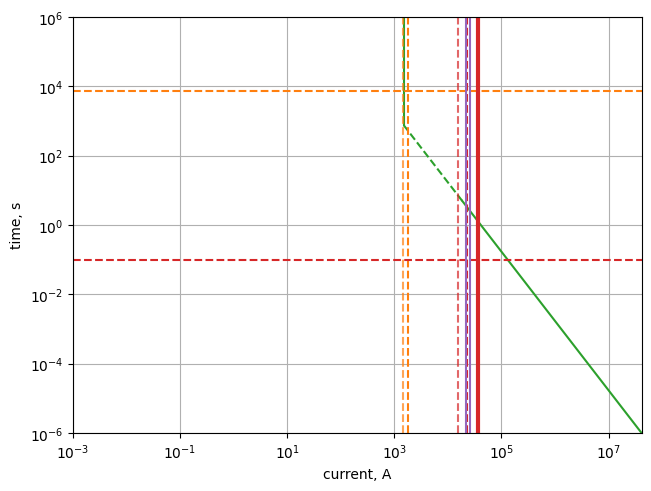

In [25]:
plt_C1 = network.plot_cable("cable_C1")
plt_C1.show()

### Circuit Breaker Q6

In [26]:
print(
    f"load current: {cable_C6.I_b_tot.to('A'):~P.1f}",
    f"nominal current: {cable_C6.I_n_tot.to('A'):~P.1f}",
    f"ampacity: {cable_C6.I_z_tot.to('A'):~P.1f}",
    f"maximum short-circuit current: {cable_C6.I_sc_max.to('kA'):~P.1f}",
    f"minimum short-circuit current: {cable_C6.I_sc_min.to('kA'):~P.1f}",
    sep="\n"
)

load current: 577.4 A
nominal current: 640.0 A
ampacity: 605.4 A
maximum short-circuit current: 25.1 kA
minimum short-circuit current: 19.3 kA


In [27]:
cb_Q6_sug = network.suggest_circuit_breaker(
    "cable_C6",
    prefer_adjustable=True
)
print(cb_Q6_sug)

standard: IEC 60947-2
category: adjustable
I_cu: 36 kA
k_m: 14.0


In [28]:
cb_Q6 = network.connect_circuit_breaker(
    "cable_C6",
    standard=CircuitBreaker.Standard.INDUSTRIAL,
    category=cb_Q6_sug.category,
    I_cu=cb_Q6_sug.I_cu,
    k_m=cb_Q6_sug.k_m,
)
print(cb_Q6)

I_n     = 640.0 A
I_r     = 577.4 A
I_nf    = 606.2 A
I_f     = 750.6 A
t_conv  = 2.0 h
I_m_min = 6466.3 A
I_m_max = 9699.5 A
t_m_lim = 100.0 ms


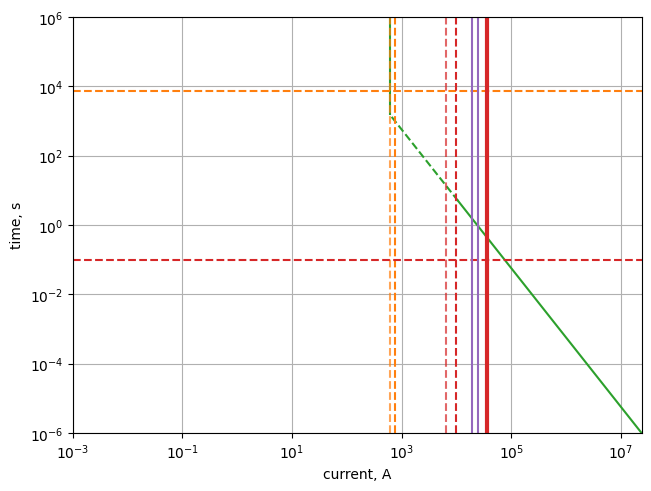

In [29]:
plt_C6 = network.plot_cable("cable_C6")
plt_C6.show()

### Check Selectivity Between CB of Upstream Cable C1 and CB of Downstream Cable C6

In [30]:
res = network.check_selectivity(up="cable_C1", down="cable_C6")
print(res)

selectivity exists: True
total selectivity: True
maximum allowable tripping-time upstream circuit breaker: 195 ms
available tripping-delay: 95 ms
